# Conditional Variational Auto Encoder

In [6]:
from keras.layers import Lambda, Input, Dense
from keras.layers import Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.models import Model
from keras import metrics
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils import plot_model

from keras.applications.inception_v3 import InceptionV3

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# hyper parameters
input_shape = (28, 28, 1)
num_classes = 10
intermediate_dim = 512
latent_dim = 2
epochs = 50
batch_size = 128
labeled_num = 100
unlabeled_num = 60000 - 100
steps_per_epoch = unlabeled_num // batch_size + 1

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# layersリストの中にさらにリストがあっても、ネットワークがつながる。
def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [5]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
#########
# Input layer
#########
x_in = Input(shape=input_shape, name='input')
y_in = Input(shape=(num_classes,), name='label_input')


########
# encoder
########
x = Flatten()(x_in)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(x_in, [z_mean, z_log_var, z], name='encoder')

########
# classifier
########
classifier_layers = [
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
]
y_output = inst_layers(classifier_layers, x_in)
classifier = Model(x_in, y_output, name='classifier')

########
# decoder
########
decoder_layers = [
    Dense(intermediate_dim, activation='relu'),
    Dense(7*7*32, activation='relu'),
    Reshape((7, 7, 32)),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=1, kernel_size=1, strides=1, activation='sigmoid', padding='same'),
]
# labeled decoder
merged = concatenate([y_in, z])
x_out = inst_layers(decoder_layers, merged)
# Unlabeled decoder
u_merged = concatenate([y_output, z])
u_x_out = inst_layers(decoder_layers, u_merged)

## Loss function

In [10]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = np.prod(input_shape) * metrics.binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

def cls_loss(y, y_pred, N=1000):
    alpha = 0.1 * N
    return alpha * metrics.categorical_crossentropy(y, y_pred)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(y_output, y_output)
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(y_output * labeled_loss, axis=-1)) + entropy

In [ ]:
basemodel = InceptionV3(weight='imagenet', input_shape=(256,256,3), include)

In [11]:
# instantiate C-VAE model
# x_out = decoder([y_in, encoder(encoder_input)[2]])
labeled_vae = Model([x_in, y_in], [x_out, y_output], name='label_c_vae')
unlabeled_vae = Model(x_in, u_x_out, name='unlabel_c_vae')

labeled_vae.compile(optimizer='adam', loss=[labeled_vae_loss, cls_loss])
unlabeled_vae.compile(optimizer='adam', loss=[unlabeled_vae_loss])

In [12]:
plot_model(labeled_vae, to_file='label_c_vae_model.png', show_shapes=True)
plot_model(unlabeled_vae, to_file='unlabel_c_vae_model.png', show_shapes=True)

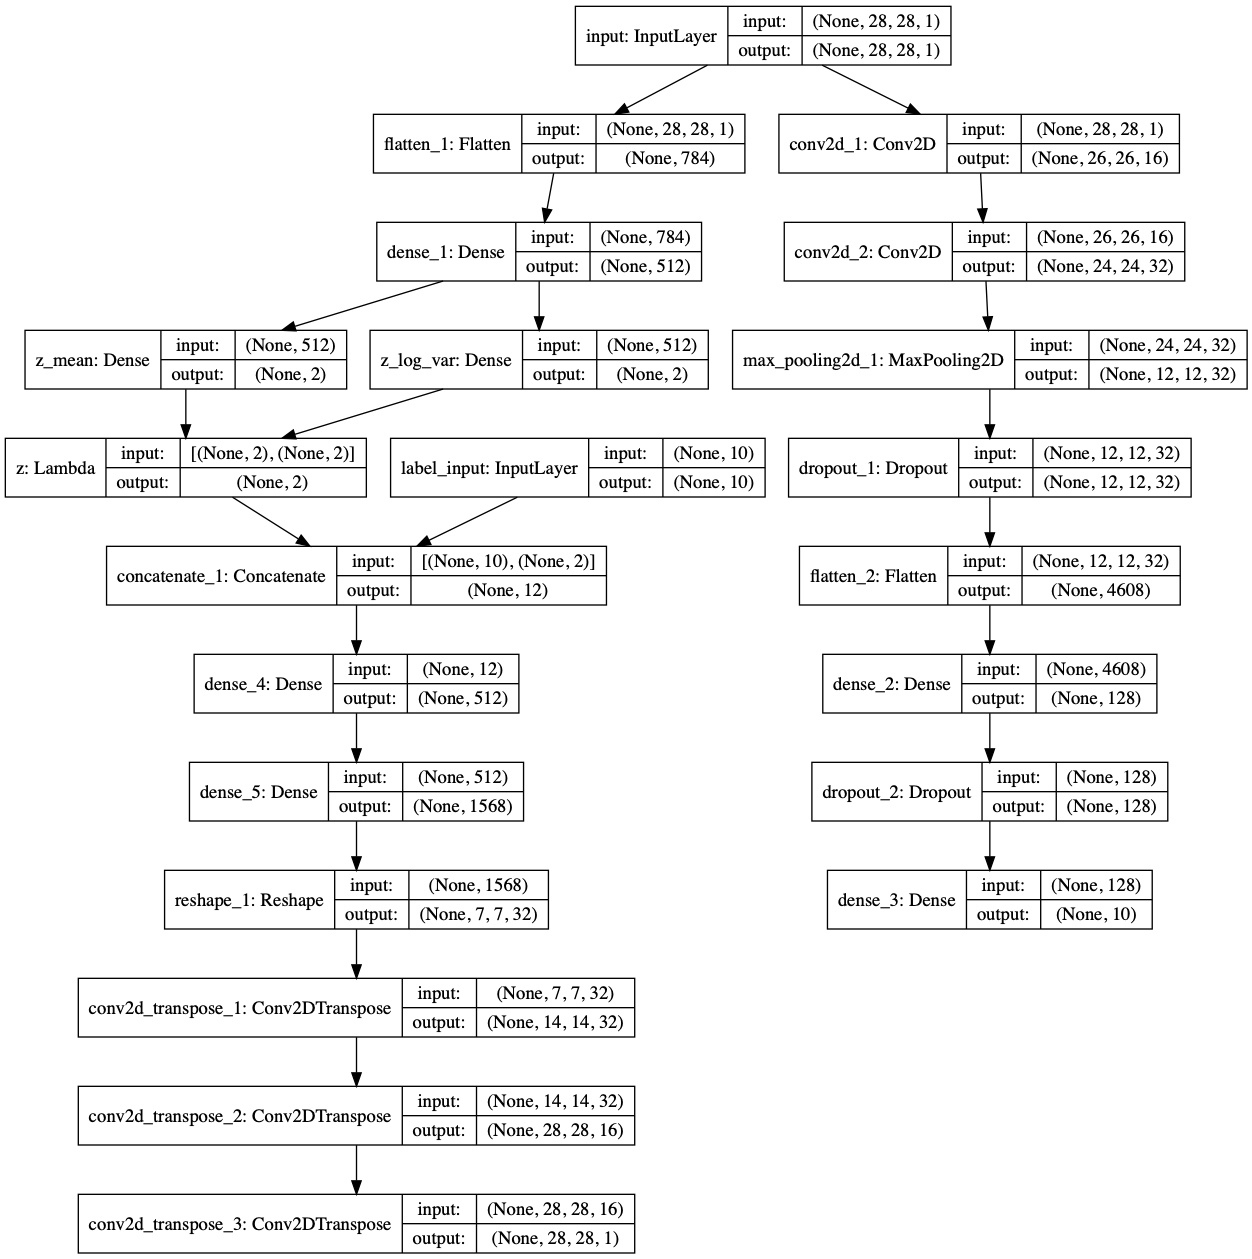

In [13]:
from keras.preprocessing.image import load_img
load_img('label_c_vae_model.png')

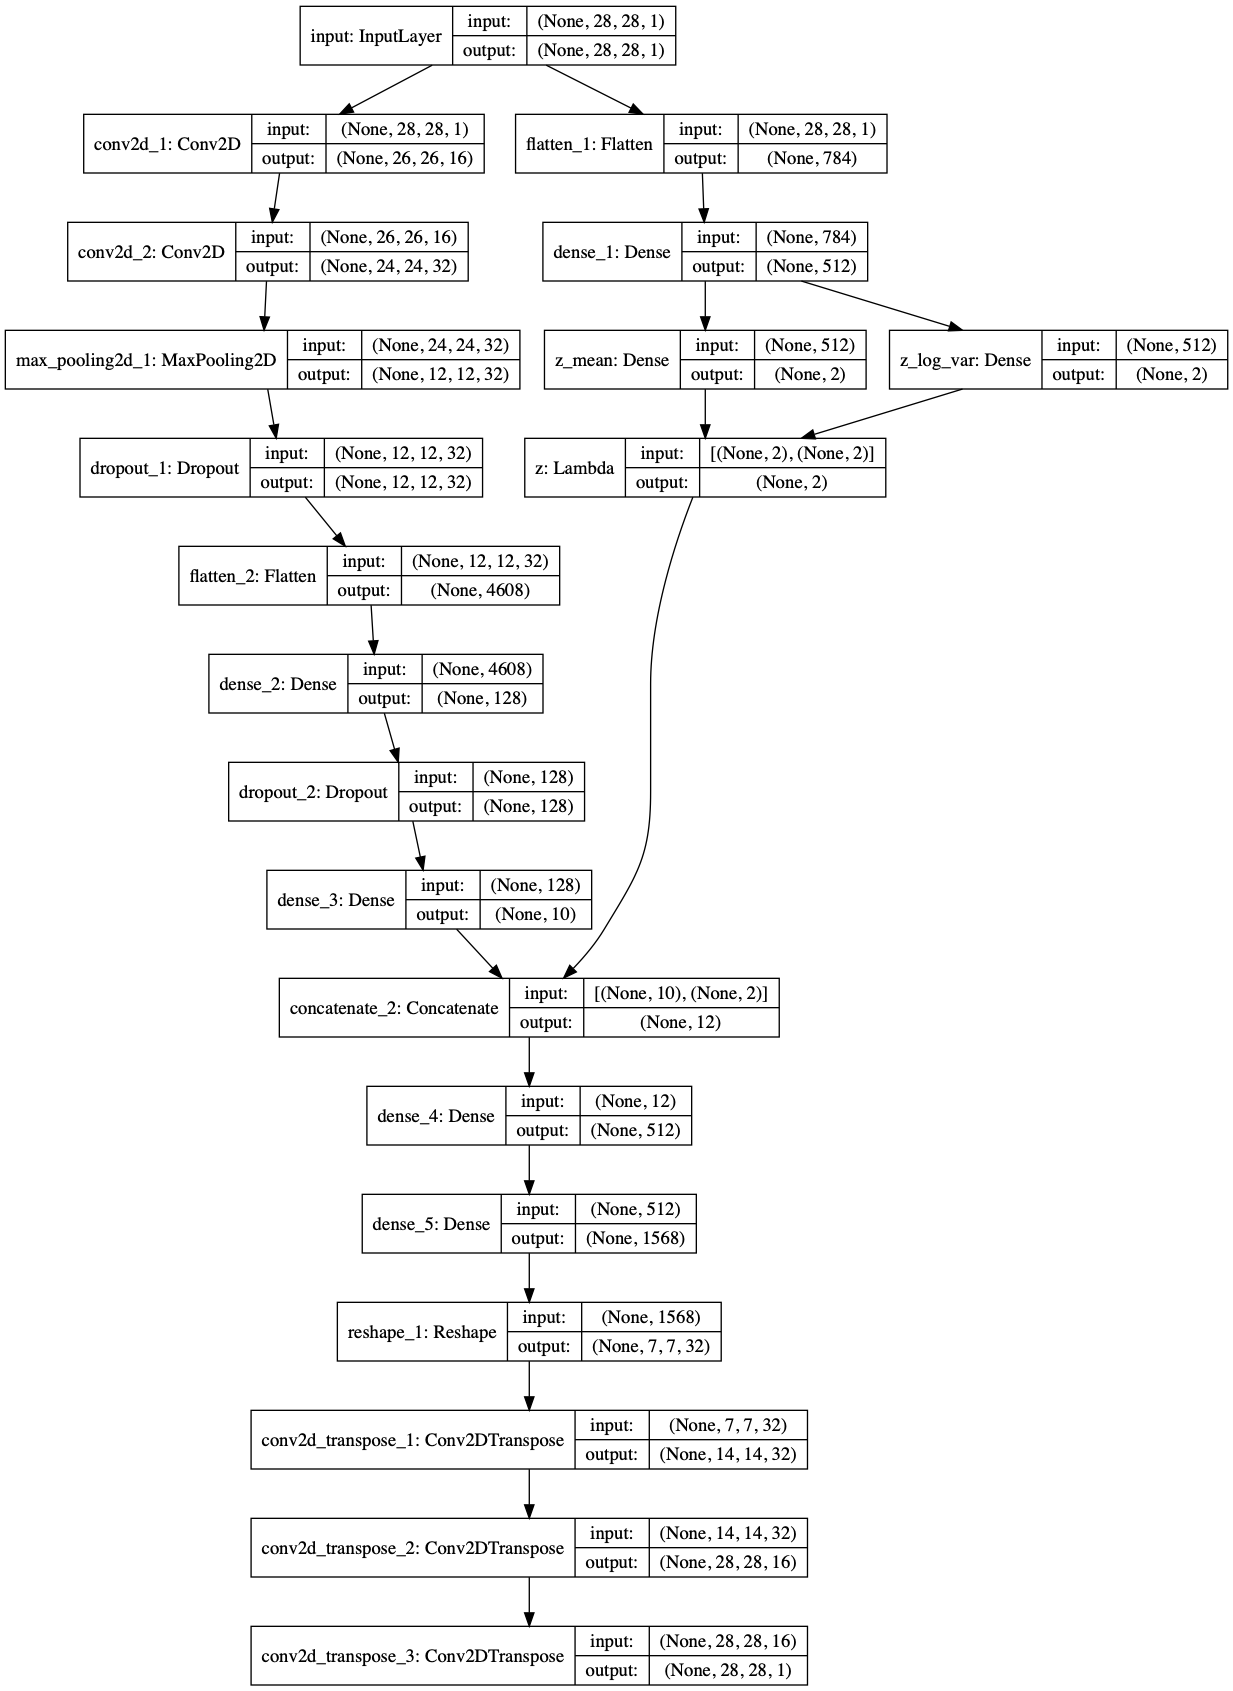

In [14]:
load_img('unlabel_c_vae_model.png')

## prepare training data (labeled / unlabeled)

In [15]:
num_samples = 10
x_labeled = []
y_labeled = []
x_unlabeled = []

for class_index in range(10):
    label_index = np.where(y_train == class_index)
    class_input_data = x_train[label_index]
    
    # labeled data
    x_labeled.append(class_input_data[:num_samples])
    y_labeled.append(np.full(num_samples, class_index, int))
    
    # unlabeled data
    x_unlabeled.append(class_input_data[num_samples:])
    
x_labeled = np.concatenate(x_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
x_labeled = x_labeled.astype('float32') / 255
x_unlabeled = x_unlabeled.astype('float32') / 255

x_labeled = x_labeled.reshape(x_labeled.shape+(1,))
x_unlabeled = x_unlabeled.reshape(x_unlabeled.shape+(1,))

y_labeled = np.concatenate(y_labeled, axis=0)
y_labeled_onehot = np.eye(num_classes)[y_labeled]


# test data
x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(x_test.shape+(1,))
y_test = np.eye(num_classes)[y_test]

In [16]:
print('labeled input_shape: {}, {}\nunlabeled input_shape: {}'.format(x_labeled.shape, y_labeled_onehot.shape, x_unlabeled.shape))
print('test input_shape: ', x_test.shape, y_test.shape)

labeled input_shape: (100, 28, 28, 1), (100, 10)
unlabeled input_shape: (59900, 28, 28, 1)
test input_shape:  (10000, 28, 28, 1) (10000, 10)


## まずは少量の教師あり(10ショット)学習

In [17]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               589952    
__________

In [18]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = classifier.fit(x_labeled, y_labeled_onehot, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Train on 100 samples, validate on 10000 samples
Epoch 1/50
100/100 [==============================] - 3s 26ms/step - loss: 2.3049 - acc: 0.1000 - val_loss: 2.2273 - val_acc: 0.3148
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - loss: 2.1787 - acc: 0.3200 - val_loss: 2.1582 - val_acc: 0.3853
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 2.1123 - acc: 0.3300 - val_loss: 2.0810 - val_acc: 0.4434
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 1.9533 - acc: 0.5600 - val_loss: 1.9893 - val_acc: 0.5084
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - loss: 1.8181 - acc: 0.5700 - val_loss: 1.8805 - val_acc: 0.5398
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - loss: 1.6852 - acc: 0.6500 - val_loss: 1.7598 - val_acc: 0.5695
Epoch 7/50
100/100 [==============================] - 2s 18ms/step - loss: 1.5379 - acc: 0.6300 - val_loss: 1.6350 - val_acc: 0.6094
Epoch 8/50
100/100 [=

In [20]:
def plot_history(history):
    # 精度の履歴をプロット
    if 'acc' in history.history:
        plt.plot(history.history['acc'], "o-", label="accuracy")
        if 'val_acc' in history.history:
            plt.plot(history.history['val_acc'], "o-", label="validation_accuracy")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1.05])
        plt.legend(loc="upper left")
        plt.show()

    # 損失の履歴をプロット
    if 'loss' in history.history:
        plt.plot(history.history['loss'],"o-",label="loss",)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], "o-", label="val_loss")
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='lower right')
        plt.show()

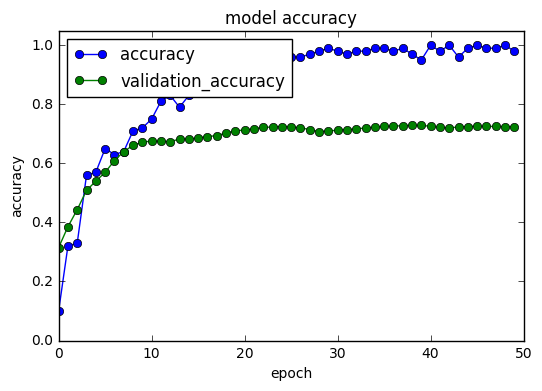

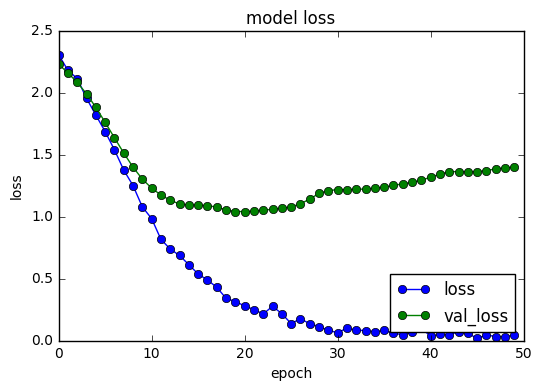

In [21]:
plot_history(history)

In [23]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [27]:
reset_weights(classifier)

## 半教師あり学習(semi-supervised learning)

In [25]:
# 教師なしの枚数が、教師ありと一致するようにリピート
labeled_index = []
for i in range(len(x_unlabeled) // len(x_labeled)):
    l = np.arange(len(x_labeled))
    np.random.shuffle(l)
    labeled_index.append(l)
labeled_index = np.concatenate(labeled_index)

#　教師ありのシャッフル
unlabeled_index = np.arange(len(x_unlabeled))

In [ ]:
loss, validation_history = [], []
for epoch in range(epochs):
    print('epoch {}/{}'.format(epoch+1, epochs))
    np.random.shuffle(unlabeled_index)
    
    for i in range(steps_per_epoch-1):
        print('step {}/ {}'.format(i+1, steps_per_epoch-1))
        # Labeled
        index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
        loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                        [x_labeled[index_range], y_labeled_onehot[index_range]])

        # Unlabeled
        index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
        loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
        
    # final step
        
    # Labeled
    index_range =  labeled_index[(steps_per_epoch-1) * batch_size:]
    loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                    [x_labeled[index_range], y_labeled_onehot[index_range]])

    # Unlabeled
    index_range =  unlabeled_index[(steps_per_epoch-1) * batch_size:]
    loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
    # validation accuracy
    history = classifier.evaluate(x_test, y_test)
    print(history)
    validation_history.append(history)

epoch 1/50
step 1/ 467
step 2/ 467
step 3/ 467
step 4/ 467
step 5/ 467
step 6/ 467
step 7/ 467
step 8/ 467
step 9/ 467
step 10/ 467
step 11/ 467
step 12/ 467
step 13/ 467
step 14/ 467
step 15/ 467
step 16/ 467
step 17/ 467
step 18/ 467
step 19/ 467
step 20/ 467
step 21/ 467
step 22/ 467
step 23/ 467
step 24/ 467
step 25/ 467
step 26/ 467
step 27/ 467
step 28/ 467
step 29/ 467
step 30/ 467
step 31/ 467
step 32/ 467
step 33/ 467
step 34/ 467
step 35/ 467
step 36/ 467
step 37/ 467
step 38/ 467
step 39/ 467
step 40/ 467
step 41/ 467
step 42/ 467
step 43/ 467
step 44/ 467
step 45/ 467
step 46/ 467
step 47/ 467
step 48/ 467
step 49/ 467
step 50/ 467
step 51/ 467
step 52/ 467
step 53/ 467
step 54/ 467
step 55/ 467
step 56/ 467
step 57/ 467
step 58/ 467
step 59/ 467
step 60/ 467
step 61/ 467
step 62/ 467
step 63/ 467
step 64/ 467
step 65/ 467
step 66/ 467
step 67/ 467
step 68/ 467
step 69/ 467
step 70/ 467
step 71/ 467
step 72/ 467
step 73/ 467
step 74/ 467
step 75/ 467
step 76/ 467
step 77/ 4